### Install packages ###

In [1]:
options(warn = -1)
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(igraph))

#Import library
library(ggplot2, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(igraph, quietly = TRUE)
library(tidygraph) 
library(ggraph)
library(ggExtra) 



 次のパッケージを付け加えます: ‘tidygraph’ 


 以下のオブジェクトは ‘package:igraph’ からマスクされています:

    groups


 以下のオブジェクトは ‘package:stats’ からマスクされています:

    filter




In [2]:
# Workspace
rm(list=ls())
workdir = "../" # Set your path
# workdir = "~/Dropbox/0_Jupyter/MpV_paper_GitHub/src"
setwd(workdir)
# getwd()

Load data from the FlashWeave analysis

In [3]:
# Load FlashWeave result (a<0.01)
posi.list <- read_tsv("./data/run220901_e2.positive.edgelist.tsv", col_names = TRUE, show_col_types = FALSE)

# Load tax information
MicV_tax <- read_tsv("./data/MicV_total_ids_clades2.txt", col_names = TRUE, show_col_types = FALSE)
Mic_tax <- read_tsv("./data/Mic_total_ids_clades2.txt", col_names = TRUE, show_col_types = FALSE)
# Make new lists
otu_merge <- rbind(MicV_tax, Mic_tax)
colnames(otu_merge)[1] <- "name"

# Load Thermal optima
MicV_optT <- read_tsv("./data/thermotype_list.txt", col_names = TRUE, show_col_types = FALSE)
colnames(MicV_optT)[1] <- "name"
# Load Thermal optima
Host_optT <- read_tsv("./data/thermotype_list_host.txt", col_names = TRUE, show_col_types = FALSE)
colnames(Host_optT)[1] <- "name"
# Merge tax and optimal temperature
All_optT <- rbind(MicV_optT, Host_optT)
otu_merge2 <- otu_merge %>% left_join(All_optT, by = "name")


# Virus-host table having significant positive correlation (drawn in the network)
posi.list.vh <- read_tsv("./data/run220901_e2.positive.edgelist.vh.tsv", col_names = TRUE, show_col_types = FALSE) %>% mutate_at(vars(id:id2),as.character)
posi.list.vv <- read_tsv("./data/run220901_e2.positive.edgelist.vv.tsv", col_names = TRUE, show_col_types = FALSE) %>% mutate_at(vars(id:id2),as.character)
posi.list.hh <- read_tsv("./data/run220901_e2.positive.edgelist.hh.tsv", col_names = TRUE, show_col_types = FALSE) %>% mutate_at(vars(id:id2),as.character)
# All the seq names were converted from "numeric" to "character"

Define modules

In [4]:
# Convert df to tbl_graph object
g <- as_tbl_graph(posi.list, directed = FALSE) # if directed graph, chose TRUE

# Add degree
g <-  g %>% mutate(degree = centrality_degree())
# Hub score
g <-  g %>% mutate(hub_score = hub_score(g, weights=NA)$vector)

# Add clade, subclade, and domain info
g <- g %>% left_join(otu_merge2, by = "name")


Visualizing the network with optimal temperatures (Fig. 3a)

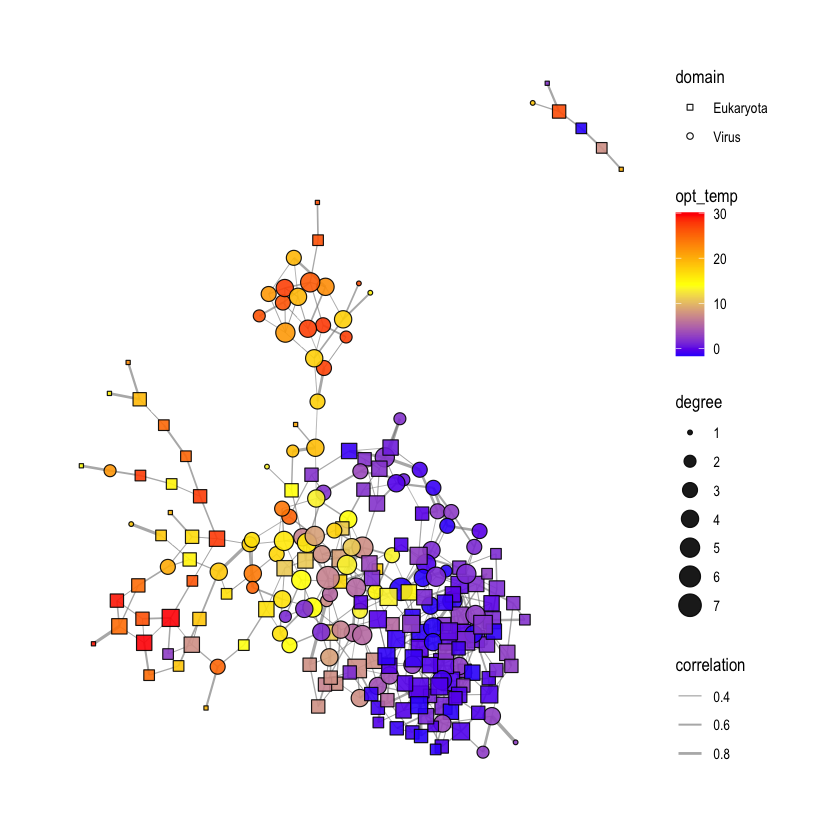

In [5]:
plot_nw <- g %>%
  #filter(degree >= 2) %>% 
  ggraph(layout = "kk") +  # chose kk, fr, or graphopt
  geom_edge_link(aes(width=correlation), alpha = 0.6, colour = "gray50") +
  geom_node_point(aes(shape = domain, size = degree, fill= opt_temp), alpha=0.9) +
  scale_edge_width(range = c(0.2, 1)) +
  scale_fill_gradient2(low="blue", mid = "yellow", high="red", midpoint = 14, na.value = "white") +
  scale_shape_manual(values = c(22,21)) +
  theme_graph(background = "NA")
plot_nw

#Save
#quartz(type="pdf", width=10, height=6, dpi = 300, file = "figure3a.virus_host_clade_optT_stress.pdf")
#plot_nw
#dev.off()



	Pearson's product-moment correlation

data:  posi.optT.hh$id1_opt_temp and posi.optT.hh$id2_opt_temp
t = 19.433, df = 188, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7635413 0.8594683
sample estimates:
      cor 
0.8170836 



	Pearson's product-moment correlation

data:  posi.optT.vh$id1_opt_temp and posi.optT.vh$id2_opt_temp
t = 13.159, df = 101, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7104910 0.8565296
sample estimates:
      cor 
0.7947408 



	Pearson's product-moment correlation

data:  posi.optT.vv$id1_opt_temp and posi.optT.vv$id2_opt_temp
t = 19.246, df = 125, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8129352 0.9028902
sample estimates:
      cor 
0.8646882 


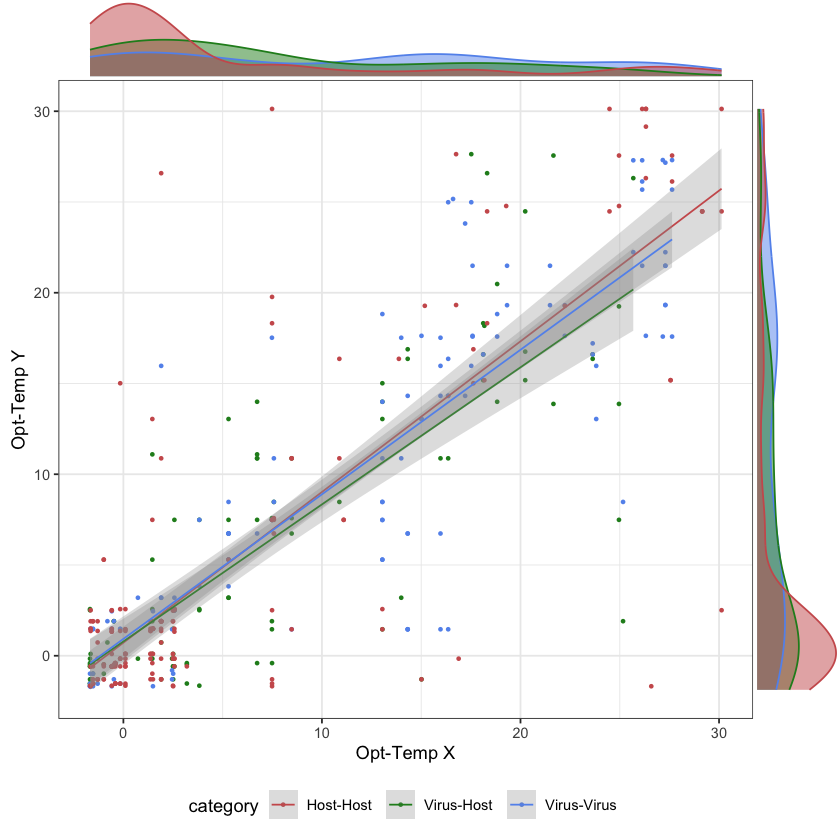

In [6]:
# Make df of positive paires and their cor, optTs
All_optT_id1 <- All_optT[,c(1,2,4)]
All_optT_id2  <- All_optT[,c(1,2,4)]
colnames(All_optT_id1)[1] <- "id"
colnames(All_optT_id2)[1] <- "id2"

# Make a table summarizing the id pairs of edges, their correlation, their own average frequency, optT, and edge category
# Host-Host
posi.optT.hh <- posi.list.hh %>% 
  left_join(All_optT_id1, by="id") %>% 
  dplyr::rename(id1_mean_freq = mean_freq, id1_opt_temp = opt_temp) %>% 
  left_join(All_optT_id2, by="id2") %>% 
  dplyr::rename(id2_mean_freq = mean_freq, id2_opt_temp = opt_temp) %>% 
  mutate(category = "Host-Host")

# Virus-Host
posi.optT.vh <- posi.list.vh %>% 
  left_join(All_optT_id1, by="id") %>% 
  dplyr::rename(id1_mean_freq = mean_freq, id1_opt_temp = opt_temp) %>% 
  left_join(All_optT_id2, by="id2") %>% 
  dplyr::rename(id2_mean_freq = mean_freq, id2_opt_temp = opt_temp) %>% 
  mutate(category = "Virus-Host")

# Virus-virus
posi.optT.vv <- posi.list.vv %>% 
  left_join(All_optT_id1, by="id") %>% 
  dplyr::rename(id1_mean_freq = mean_freq, id1_opt_temp = opt_temp) %>% 
  left_join(All_optT_id2, by="id2") %>% 
  dplyr::rename(id2_mean_freq = mean_freq, id2_opt_temp = opt_temp) %>% 
  mutate(category = "Virus-Virus")

# Merge df
posi.optT.all <- dplyr::bind_rows(posi.optT.vh, posi.optT.vv, posi.optT.hh)

# Extract correlatiion
cor.test(posi.optT.hh$id1_opt_temp, posi.optT.hh$id2_opt_temp)
cor.test(posi.optT.vh$id1_opt_temp, posi.optT.vh$id2_opt_temp)
cor.test(posi.optT.vv$id1_opt_temp, posi.optT.vv$id2_opt_temp)

# Define color
col_tax  <- c("indianred", "forestgreen", "cornflowerblue")

# Plot correlation
sc1 <- ggplot(posi.optT.all, aes(x=id1_opt_temp, y=id2_opt_temp, color=category)) + theme_bw() +
  #ylim(-1,1) +
  geom_point(size=1, shape=16, alpha=1.0) +
  scale_color_manual(values = col_tax) +
  theme(legend.position="bottom", legend.direction = "horizontal") +
  stat_smooth(method=lm, formula = 'y ~ x', size = 0.5, alpha=0.3, fullrange = FALSE, se = TRUE) +
  xlab("Opt-Temp X") + ylab("Opt-Temp Y")
# Add density plot
scd1 <- ggMarginal(sc1, type = "density", size = 8, margins = "both", groupColour = TRUE, groupFill = TRUE)
print(scd1)
# ggsave(filename = "figure3b.network.optT.pdf", plot= scd1, width=120, height=125, units="mm", dpi = 300)
